# Explainable AI

Making models is really cool, but in practice, in businesses people often also want to know why a certain prediction was made. Understanding why predictions are made is the field of Explainable AI. It can be as important, and in some cases, even more important as making the most accurate prediction. 

SHAP (SHapley Additive exPlainations) is a game theoretic approach to explain the output of any machine learning model to increase transparency and interpretability of machine learning models. Consider a coooperative game with the same number of players as the name of features. SHAP will disclose the individual contribution of each player (or feature) on the output of the model, for each example or observation.

*Important: while SHAP shows the contribution or the importance of each feature on the prediction of the model, it does not evaluate the quality of the prediction itself.*

SHAP can thus be applied to all kinds of models. SHAP has different ways of working for different kinds of models, in this notebook we will first go through SHAP for tabular data. We will first make an XG Boost model, which is a tree model. We will use the breast_cancer dataset that has 30 variables and 1 target which is binary and shows whether the person has breast cancer or not. SHAP will help us understand which of these 30 variables made the largest difference in a single prediction. If we calculate the mean SHAP values over all these samples, we can say which of the variables are most important.

In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
from sklearn import datasets
import pandas as pd
import numpy as np
import shap
import torch

In [3]:
from src.data.make_dataset import get_breast_cancer_dataset

train_perc = 0.8
traindataset, testdataset, featurenames = get_breast_cancer_dataset(train_perc)

len(traindataset), len(testdataset)

Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?


(455, 114)

In [4]:
from src.data.data_tools import BaseDatastreamer

def preprocessor(batch):
    X, Y = zip(*batch)
    return torch.stack(X), torch.tensor(Y)

trainstreamer = BaseDatastreamer(traindataset, batchsize=32, preprocessor=preprocessor).stream()
teststreamer = BaseDatastreamer(testdataset, batchsize=len(testdataset), preprocessor=preprocessor).stream()

In [5]:
X, Y = next(trainstreamer)
X.shape, Y.shape

(torch.Size([32, 30]), torch.Size([32]))

In [7]:
import torch.optim as optim
from src.models import metrics
from src.models import train_model
from src.models.linear import NeuralNetwork
from pathlib import Path


config = {
    "input" : 30,
    "h1" : 20,
    "h2" : 10,
    "output" : 2
}
model = NeuralNetwork(config)

loss_fn = torch.nn.CrossEntropyLoss()
accuracy = metrics.Accuracy()

log_dir="../../models/test"


model, loss = train_model.trainloop(
    epochs=50,
    model=model,
    optimizer=optim.Adam,
    learning_rate=1e-3,
    weight_decay=1e-2,
    loss_fn=loss_fn,
    metrics=[accuracy],
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=int(train_perc * len(traindataset)) // 32,
    eval_steps=1,
    tunewriter=["tensorboard"]
)

2023-05-23 07:54:06.076 | INFO     | src.data.data_tools:dir_add_timestamp:137 - Logging to ../../models/test/20230523-0754
100%|██████████| 11/11 [00:00<00:00, 59.63it/s]
2023-05-23 07:54:06.311 | INFO     | src.models.train_model:trainloop:189 - Epoch 0 train 7.7965 test 6.6314 metric ['0.2281']
100%|██████████| 11/11 [00:00<00:00, 257.96it/s]
2023-05-23 07:54:06.369 | INFO     | src.models.train_model:trainloop:189 - Epoch 1 train 3.2060 test 0.8540 metric ['0.2281']
100%|██████████| 11/11 [00:00<00:00, 319.73it/s]
2023-05-23 07:54:06.425 | INFO     | src.models.train_model:trainloop:189 - Epoch 2 train 0.8449 test 0.6227 metric ['0.5614']
100%|██████████| 11/11 [00:00<00:00, 168.18it/s]
2023-05-23 07:54:06.523 | INFO     | src.models.train_model:trainloop:189 - Epoch 3 train 0.6704 test 0.6915 metric ['0.2719']
2023-05-23 07:54:06.528 | INFO     | src.models.train_model:__call__:288 - best loss: 0.6227022409439087, current loss 0.691479. Counter 1.000000/10.
100%|██████████| 11/11 

We have a model! Now we can start using the SHAP values to analyze the model

Because we are using a Neural network, we are using the DeepExplainer.

In [15]:
import shap
import pandas as pd

X, Y = next(teststreamer)
explainer = shap.DeepExplainer(model, X)
shap_values = explainer.shap_values(X)

#make a dataframe of the data so that we can add the feature names in our plots
df = pd.DataFrame(X.numpy(), columns=featurenames)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


### Visualize a single prediction

We can visualize a single prediction. 

For this we can use the force plot, which is a way to see the effect of each feature on the prediction, for a given observation. In this plot the positive SHAP values are displayed on the left side and the negative on the right side, as if competing against each other. The highlighted value is the prediction for that observation.



In [16]:
explainer.expected_value

array([-0.68078446, -0.42536226], dtype=float32)

<ol>
    <li>The output value is the prediction for that observation </li>
    <li>The base value: the mean prediction, or mean(yhat)</li>
    <li>Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.</li>
    <li>The plot is centered on the x-axis at explainer.expected_value. All SHAP values are relative to the model's expected value like a linear model's effects are relative to the intercept.</li>
<ol>


In [17]:
import pandas as pd

#init javascript in order to display the visuals
shap.initjs()


category = 1
observation = 3
print(Y[observation])
shap_value = np.array(shap_values[category][observation, :])
features = df.iloc[observation,:]
shap.force_plot(explainer.expected_value[category], shap_value, features)

tensor(1, dtype=torch.uint8)


In [18]:
df.mean()

mean radius                 13.696019
mean texture                20.487633
mean perimeter              89.037094
mean area                  618.742065
mean smoothness              0.095948
mean compactness             0.101718
mean concavity               0.078500
mean concave points          0.043205
mean symmetry                0.176539
mean fractal dimension       0.063427
radius error                 0.380406
texture error                1.279490
perimeter error              2.716534
area error                  38.024864
smoothness error             0.007233
compactness error            0.024128
concavity error              0.029632
concave points error         0.011261
symmetry error               0.018946
fractal dimension error      0.003743
worst radius                15.547357
worst texture               26.739649
worst perimeter            102.577820
worst area                 807.755371
worst smoothness             0.131651
worst compactness            0.239269
worst concav

### Bar chart of mean importance

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

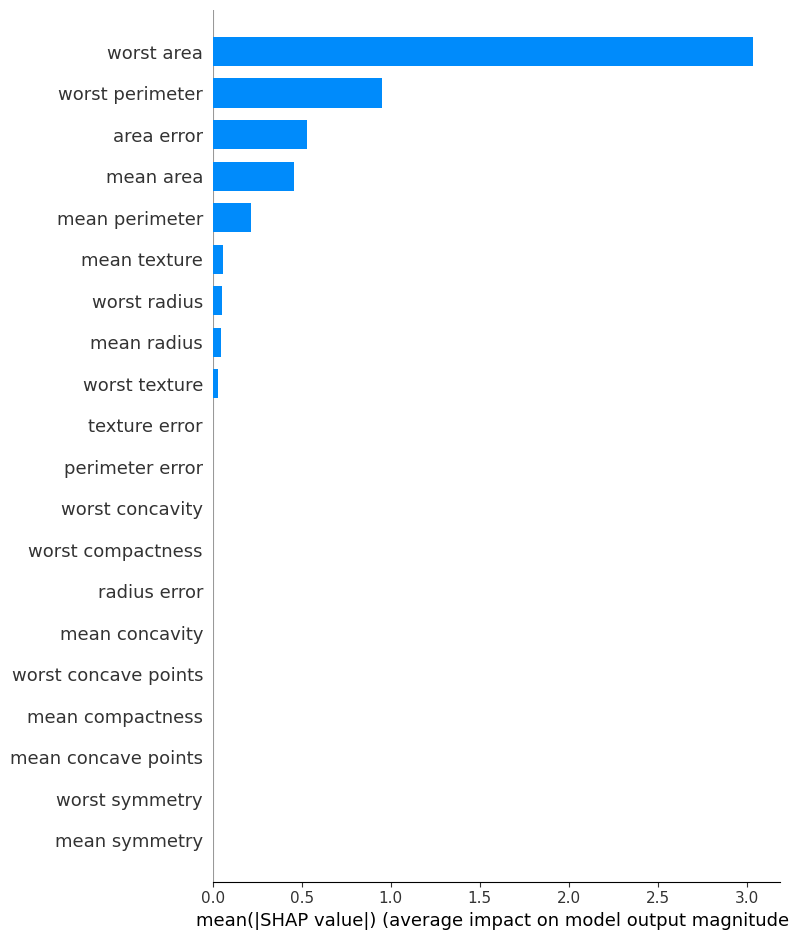

In [19]:
shap.summary_plot(shap_values[1], df, plot_type="bar")

### SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don’t fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


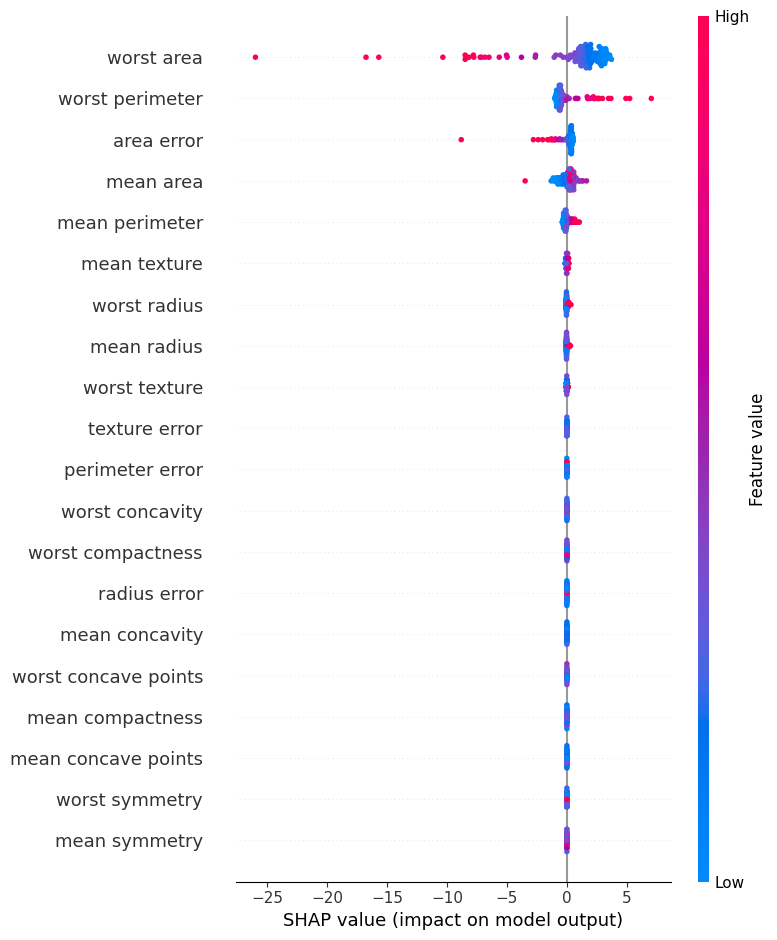

In [20]:
shap.summary_plot(shap_values[1], df)

So that's it for the tabular data. We can also use SHAP for images. See the next notebook for SHAP on image data.